In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import math

**DATA PREPROCESSING**

In [52]:
with open('dataset/data.csv', 'r') as f:
    print(f.readline().replace('\n','').split(','))

['Country name', 'Ladder score', 'Standard error of ladder score', 'upperwhisker', 'lowerwhisker', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Ladder score in Dystopia', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual']


In [53]:
# Create 2-D array "data"
data = []
with open('dataset/data.csv', 'r') as f:
    line = f.readline()
    line = line.replace('\n', '').split(',')
    data.append(line)
    for line in f.readlines():
        line = line.replace('\n', '').split(',')
        line_int = [line[0]]
        for i in range(1,len(line)):
            if line[i] == '':
                line_int.append(0.0)
                continue
            line_int.append(float(line[i]))
        data.append(line_int)


In [54]:
# Create "dataframe"
dataframe = pd.DataFrame(data[1:], columns = data[0])

**NAIVE**

/var/folders/kd/k2fmn5590c3g3b92s89c6fl80000gn/T/ipykernel_877/1692850632.py:17: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_y_axes().join(axs[1, 0], axs[1, 1])
/var/folders/kd/k2fmn5590c3g3b92s89c6fl80000gn/T/ipykernel_877/1692850632.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_xticklabels(top_ten_happiness['Country name'], rotation=90)
/var/folders/kd/k2fmn5590c3g3b92s89c6fl80000gn/T/ipykernel_877/1692850632.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_xticklabels(top_ten_gdp['Country name'], rotation=90)


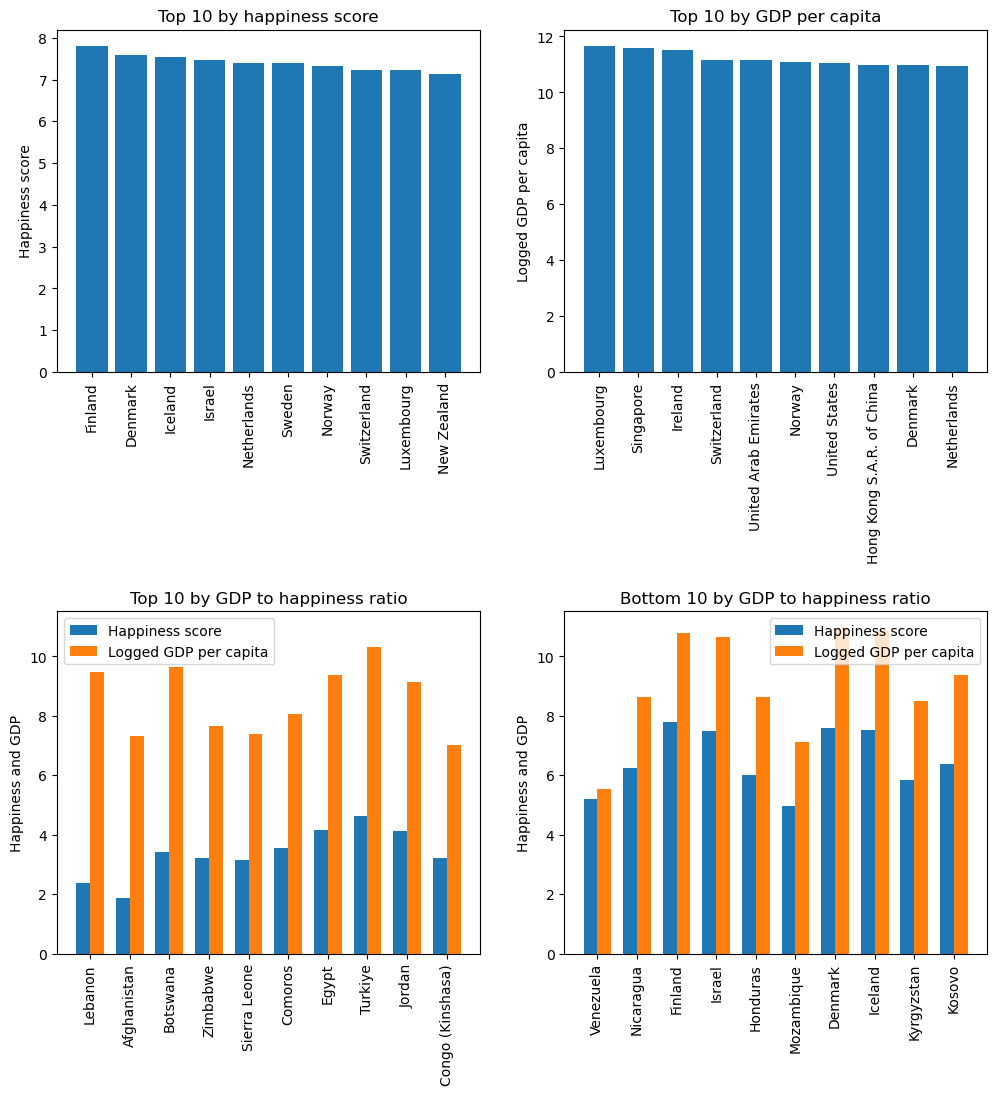

In [55]:
# 4 top 10 plots
top_ten_happiness = dataframe.head(10)

sorted_df_gdp = dataframe.sort_values(by='Logged GDP per capita', ascending=False)
top_ten_gdp = sorted_df_gdp.head(10)

# dataframe['GDP to happiness ratio'] = (math.e**dataframe['Logged GDP per capita'])/dataframe['Ladder score']
dataframe['GDP to happiness ratio'] = (dataframe['Logged GDP per capita'])/dataframe['Ladder score']
sorted_df_ratio = dataframe.sort_values(by='GDP to happiness ratio', ascending=False)
top_ten_ratio = sorted_df_ratio.head(10)
sorted_df_ratio_reverse = dataframe.sort_values(by='GDP to happiness ratio', ascending=True)
last_ten_ratio = sorted_df_ratio_reverse.head(10)


fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[1, 0].get_shared_y_axes().join(axs[1, 0], axs[1, 1])

axs[0,0].bar(top_ten_happiness['Country name'], top_ten_happiness['Ladder score'])
axs[0,0].set_ylabel('Happiness score')
axs[0,0].set_title('Top 10 by happiness score')
axs[0,0].set_xticklabels(top_ten_happiness['Country name'], rotation=90)

axs[0,1].bar(top_ten_gdp['Country name'], top_ten_gdp['Logged GDP per capita'])
axs[0,1].set_ylabel('Logged GDP per capita')
axs[0,1].set_title('Top 10 by GDP per capita')
axs[0,1].set_xticklabels(top_ten_gdp['Country name'], rotation=90)

index = [i for i in range(0,10)]
axs[1,0].bar(index, top_ten_ratio['Ladder score'], 0.35, label = "Happiness score")
# axs[1,0].bar([i+0.35 for i in index], math.e**top_ten_ratio['Logged GDP per capita'], 0.35, label='Logged GDP per capita')
axs[1,0].bar([i+0.35 for i in index], top_ten_ratio['Logged GDP per capita'], 0.35, label='Logged GDP per capita')
axs[1,0].set_ylabel('Happiness and GDP')
axs[1,0].set_title('Top 10 by GDP to happiness ratio')
axs[1,0].set_xticks([i+(0.35/2) for i in index])
axs[1,0].set_xticklabels(top_ten_ratio['Country name'], rotation=90)
axs[1,0].legend()

axs[1,1].bar(index, last_ten_ratio['Ladder score'], 0.35, label = "Happiness score")
#axs[1,1].bar([i+0.35 for i in index], math.e**last_ten_ratio['Logged GDP per capita'], 0.35, label='Logged GDP per capita')
axs[1,1].bar([i+0.35 for i in index], last_ten_ratio['Logged GDP per capita'], 0.35, label='Logged GDP per capita')
axs[1,1].set_ylabel('Happiness and GDP')
axs[1,1].set_title('Bottom 10 by GDP to happiness ratio')
axs[1,1].set_xticks([i+(0.35/2) for i in index])
axs[1,1].set_xticklabels(last_ten_ratio['Country name'], rotation=90)
axs[1,1].legend()

plt.subplots_adjust(hspace=0.7)

plt.show()

**DEEP LEARNING PREDICTION USING GDP**

In [56]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import save_model
from keras.models import load_model
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, Range1d

In [57]:
# Label regions of countries for future use
region_data = []
with open('dataset/country_region.csv', 'r') as f:
    line = f.readline()
    line = line.replace('\n', '').split(',')
    region_data.append(line)
    for line in f.readlines():
        line = line.replace('\n', '').split(',')
        region_data.append(line)
        if len(line)==12:
            print(line[0])

region_dataframe = pd.DataFrame(region_data[1:], columns = region_data[0])

# Get a dictionary matching each country to their corresponding region
country_region = {}
countries, regions = region_dataframe['name'].tolist(), region_dataframe['sub-region'].tolist()
for i in range(len(countries)):
    country_region[countries[i]] = regions[i]

# Get the full list of regions
regions = list(set(regions))
regions.sort()

# Add columns to dataframe
for region in regions:
    dataframe[region] = 0

# Label the region of each country
for index, row in dataframe.iterrows():
    region = country_region[row['Country name']]
    dataframe.at[index, region] = 1

In [58]:
shuffled_dataframe = dataframe.sample(frac=1).reset_index(drop=True)

In [59]:
model = Sequential()

model.add(Dense(64, input_shape=(1,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

model.fit(shuffled_dataframe['Logged GDP per capita'][:100], shuffled_dataframe['Ladder score'][:100], epochs=1000)

# Evaluate the model using the test data (37 items from column x and y)
loss = model.evaluate(shuffled_dataframe['Logged GDP per capita'][100:137], shuffled_dataframe['Ladder score'][100:137])
print("Test loss:", loss)


save_model(model, 'model_GDP.h5')

Epoch 1/1000
4/4 [==============================] - 0s 2ms/step - loss: 3.5552
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 2.1405
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.9136
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7775
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.9005
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6172
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6169
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6465
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6145
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5783
Epoch 11/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.5878
Epoch 12/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5886
Epoch 13/1000
4/4 [==============================

In [60]:
# Get predictions
def get_visualization_source(model):
    model = load_model(model)
    y_pred = model.predict(shuffled_dataframe['Logged GDP per capita'][100:137])
    y_pred = [item[0] for item in y_pred]
    y_actual = shuffled_dataframe['Ladder score'][100:137].tolist()
    labels = shuffled_dataframe['Country name'][100:137].tolist()
    return y_pred, y_actual, labels

In [61]:
# VISUALIZE with model_GDP

y_pred, y_actual, labels = get_visualization_source('model_GDP.h5')

# Visualize using HoverTool
output_file("Predicting with f(GDP per capita).html")
source = ColumnDataSource(data=dict(x=y_pred, y=y_actual, label=labels))

# Scatter plot
p = figure(title="Happiness Prediction with f(GDP per capita)", x_axis_label="Predictions", y_axis_label="Actuals")
p.scatter('x','y', source=source, size=10, fill_color='blue', line_color='black')

# Hover functionality
hover = HoverTool(tooltips=[("Country", '@label')])
p.add_tools(hover)

# y=x line
p.line([0, 10], [0, 10], line_width=2, color='red', legend_label='y=x')

# Equalize scales of axes
p.x_range = p.y_range = Range1d(start=min([min(y_pred),min(y_actual)])-1, end=max([max(y_pred),max(y_actual)])+1)

# Set font sizes
p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

show(p)

2/2 [==============================] - 0s 2ms/step


**DEEP LEARNING USING GDP AND REGION**

In [62]:
features = ['Logged GDP per capita', 'Australia and New Zealand', 'Central Asia', 'Eastern Asia',
       'Eastern Europe', 'Latin America and the Caribbean', 'Melanesia',
       'Micronesia', 'Northern Africa', 'Northern America', 'Northern Europe',
       'Polynesia', 'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Sub-Saharan Africa', 'Western Asia', 'Western Europe']
x = shuffled_dataframe[features].values


print(x)

[[ 8.962  0.     0.    ...  0.     0.     0.   ]
 [ 8.973  0.     0.    ...  0.     0.     0.   ]
 [10.341  0.     0.    ...  0.     0.     0.   ]
 ...
 [ 8.404  0.     0.    ...  0.     0.     0.   ]
 [ 9.616  0.     0.    ...  0.     0.     0.   ]
 [10.453  0.     0.    ...  0.     0.     0.   ]]


In [63]:
model = Sequential()

model.add(Dense(64, input_shape=(18,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

model.fit(x[:100], shuffled_dataframe['Ladder score'][:100], epochs=1000)

# Evaluate the model using the test data (37 items from column x and y)
loss = model.evaluate(x[100:137], shuffled_dataframe['Ladder score'][100:137])
print("Test loss:", loss)


save_model(model, 'model_GDP_region.h5')


Epoch 1/1000
4/4 [==============================] - 0s 2ms/step - loss: 4.6271
Epoch 2/1000
4/4 [==============================] - 0s 1ms/step - loss: 3.3766
Epoch 3/1000
4/4 [==============================] - 0s 1ms/step - loss: 2.1068
Epoch 4/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.8735
Epoch 5/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.0138
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 1.2406
Epoch 7/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7472
Epoch 8/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7087
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.7700
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6793
Epoch 11/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.5858
Epoch 12/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.6103
Epoch 13/1000
4/4 [==============================

In [64]:
model = load_model('model_GDP_region.h5')
y_pred = model.predict(x[100:])
y_pred = [item[0] for item in y_pred]
y_actual = shuffled_dataframe['Ladder score'][100:].tolist()
labels = shuffled_dataframe['Country name'][100:].tolist()

2/2 [==============================] - 0s 2ms/step


In [65]:
# VISUALIZE with model_GDP_region

# Visualize using HoverTool
output_file("Predicting with f(GDP per capita,region).html")
source = ColumnDataSource(data=dict(x=y_pred, y=y_actual, label=labels))

# Scatter plot
p = figure(title="Happiness Prediction with f(GDP per capita,region)", x_axis_label="Predictions", y_axis_label="Actuals")
p.scatter('x','y', source=source, size=10, fill_color='blue', line_color='black')

# Hover functionality
hover = HoverTool(tooltips=[("Country", '@label')])
p.add_tools(hover)

# y=x line
p.line([0, 10], [0, 10], line_width=2, color='red', legend_label='y=x')

# Equalize scales of axes
p.x_range = p.y_range = Range1d(start=min([min(y_pred),min(y_actual)])-1, end=max([max(y_pred),max(y_actual)])+1)

# Set font sizes
p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

show(p)

**DEEP LEARNING USING GDP AND LIFE EXPECTANCY**

In [66]:
features = ['Logged GDP per capita', 'Healthy life expectancy']
x = shuffled_dataframe[features].values

In [67]:
model = Sequential()

model.add(Dense(64, input_shape=(2,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

model.fit(x[:100], shuffled_dataframe['Ladder score'][:100], epochs=1000)

# Evaluate the model using the test data (37 items from column x and y)
loss = model.evaluate(x[100:137], shuffled_dataframe['Ladder score'][100:137])
print("Test loss:", loss)


save_model(model, 'model_GDP_health.h5')

Epoch 1/1000
4/4 [==============================] - 0s 2ms/step - loss: 1.4304
Epoch 2/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.9370
Epoch 3/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.8669
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8441
Epoch 5/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7432
Epoch 6/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7371
Epoch 7/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7185
Epoch 8/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.6955
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6821
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.6755
Epoch 11/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7031
Epoch 12/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.6764
Epoch 13/1000
4/4 [==============================

In [68]:
model = load_model('model_GDP_health.h5')
y_pred = model.predict(x[100:])
y_pred = [item[0] for item in y_pred]
y_actual = shuffled_dataframe['Ladder score'][100:].tolist()
labels = shuffled_dataframe['Country name'][100:].tolist()

2/2 [==============================] - 0s 2ms/step


In [69]:
# VISUALIZE with model_GDP_health

# Visualize using HoverTool
output_file("Predicting with f(GDP per capita,health).html")
source = ColumnDataSource(data=dict(x=y_pred, y=y_actual, label=labels))

# Scatter plot
p = figure(title="Happiness Prediction with f(GDP per capita,health)", x_axis_label="Predictions", y_axis_label="Actuals")
p.scatter('x','y', source=source, size=10, fill_color='blue', line_color='black')

# Hover functionality
hover = HoverTool(tooltips=[("Country", '@label')])
p.add_tools(hover)

# y=x line
p.line([0, 10], [0, 10], line_width=2, color='red', legend_label='y=x')

# Equalize scales of axes
p.x_range = p.y_range = Range1d(start=min([min(y_pred),min(y_actual)])-1, end=max([max(y_pred),max(y_actual)])+1)

# Set font sizes
p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

show(p)

In [70]:
print(dataframe.columns)

Index(['Country name', 'Ladder score', 'Standard error of ladder score',
       'upperwhisker', 'lowerwhisker', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual', 'GDP to happiness ratio', '""',
       'Australia and New Zealand', 'Central Asia', 'Eastern Asia',
       'Eastern Europe', 'Latin America and the Caribbean', 'Melanesia',
       'Micronesia', 'Northern Africa', 'Northern America', 'Northern Europe',
       'Polynesia', 'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Sub-Saharan Africa', 'Western Asia', 'Western Europe'],
      dtype='obj

**DEEP LEARING WITH EVERYTHING OTHER THAN REGION**

In [71]:
features = ['Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption',
       'Dystopia + residual']
x = shuffled_dataframe[features].values

In [72]:
model = Sequential()

model.add(Dense(64, input_shape=(7,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

model.fit(x[:100], shuffled_dataframe['Ladder score'][:100], epochs=1000)

# Evaluate the model using the test data (37 items from column x and y)
loss = model.evaluate(x[100:137], shuffled_dataframe['Ladder score'][100:137])
print("Test loss:", loss)


save_model(model, 'model_everything.h5')

Epoch 1/1000
4/4 [==============================] - 0s 1ms/step - loss: 9.2436
Epoch 2/1000
4/4 [==============================] - 0s 1ms/step - loss: 4.4822
Epoch 3/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.0056
Epoch 4/1000
4/4 [==============================] - 0s 1ms/step - loss: 2.3436
Epoch 5/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.6857
Epoch 6/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.8238
Epoch 7/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.2117
Epoch 8/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.9441
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.7187
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.7681
Epoch 11/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7597
Epoch 12/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.7357
Epoch 13/1000
4/4 [==============================

In [73]:
model = load_model('model_everything.h5')
y_pred = model.predict(x[100:])
y_pred = [item[0] for item in y_pred]
y_actual = shuffled_dataframe['Ladder score'][100:].tolist()
labels = shuffled_dataframe['Country name'][100:].tolist()

2/2 [==============================] - 0s 2ms/step


In [74]:
# VISUALIZE with model_everything

# Visualize using HoverTool
output_file("Predicting with f(all seven original aspects).html")
source = ColumnDataSource(data=dict(x=y_pred, y=y_actual, label=labels))

# Scatter plot
p = figure(title="Happiness Prediction with f(all seven original aspects)", x_axis_label="Predictions", y_axis_label="Actuals")
p.scatter('x','y', source=source, size=10, fill_color='blue', line_color='black')

# Hover functionality
hover = HoverTool(tooltips=[("Country", '@label')])
p.add_tools(hover)

# y=x line
p.line([0, 10], [0, 10], line_width=2, color='red', legend_label='y=x')

# Equalize scales of axes
p.x_range = p.y_range = Range1d(start=min([min(y_pred),min(y_actual)])-1, end=max([max(y_pred),max(y_actual)])+1)

# Set font sizes
p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = '15pt'
p.yaxis.axis_label_text_font_size = '15pt'

show(p)

**PRINCIPAL COMPONENT ANALYSIS**

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
X = dataframe[['Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia']]
y = dataframe['Ladder score']

rfr = RandomForestRegressor(n_estimators=100, random_state=42)

rfr.fit(X, y)

importances = rfr.feature_importances_

for feature, importance in zip(X.columns, importances):
    print('{} importance: {}'.format(feature, importance))


Logged GDP per capita importance: 0.20123242222574228
Social support importance: 0.6304935389081893
Healthy life expectancy importance: 0.03411723283380643
Freedom to make life choices importance: 0.07786307793617643
Generosity importance: 0.026784717679054135
Perceptions of corruption importance: 0.029509010417031464
Ladder score in Dystopia importance: 0.0


In [77]:
X = dataframe[['Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia','Australia and New Zealand', 'Central Asia', 'Eastern Asia',
       'Eastern Europe', 'Latin America and the Caribbean', 'Melanesia',
       'Micronesia', 'Northern Africa', 'Northern America', 'Northern Europe',
       'Polynesia', 'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Sub-Saharan Africa', 'Western Asia', 'Western Europe']]
y = dataframe['Ladder score']

rfr = RandomForestRegressor(n_estimators=100, random_state=42)

rfr.fit(X, y)

importances = rfr.feature_importances_

for feature, importance in zip(X.columns, importances):
    print('{} importance: {}'.format(feature, importance))


Logged GDP per capita importance: 0.19876621599963026
Social support importance: 0.6217808709160699
Healthy life expectancy importance: 0.02827120253914904
Freedom to make life choices importance: 0.06720840271906278
Generosity importance: 0.024530193353784438
Perceptions of corruption importance: 0.028203634764176103
Ladder score in Dystopia importance: 0.0
Australia and New Zealand importance: 0.0001264993069710206
Central Asia importance: 7.368257137588177e-05
Eastern Asia importance: 0.001506531746115319
Eastern Europe importance: 0.0004136614720021111
Latin America and the Caribbean importance: 0.01588899515079774
Melanesia importance: 0.0
Micronesia importance: 0.0
Northern Africa importance: 0.000256902307466848
Northern America importance: 2.3048015988380047e-05
Northern Europe importance: 0.00030641181990688276
Polynesia importance: 0.0
South-eastern Asia importance: 0.0005257433061791819
Southern Asia importance: 0.00744695100422059
Southern Europe importance: 0.0006990250196

**TEST FOR DIRECTION OF EFFECT OF EACH REGION**

In [149]:
regions = ['Australia and New Zealand', 'Central Asia', 'Eastern Asia',
       'Eastern Europe', 'Latin America and the Caribbean', 'Melanesia',
       'Micronesia', 'Northern Africa', 'Northern America', 'Northern Europe',
       'Polynesia', 'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Sub-Saharan Africa', 'Western Asia', 'Western Europe']
relevant_features = ['Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia']

In [150]:
# Test how each region affect the prediction
X_test = [dataframe[feature].mean() for feature in relevant_features]
for i in range(len(regions)):
    X_test.append(0)
X_test_df = pd.DataFrame([X_test], columns=relevant_features+regions)

In [151]:
predictions = []
prediction = rfr.predict(X_test_df)
print('Base:', prediction)
predictions.append(prediction)
for region in regions:
    X_test_region = X_test_df.copy()
    X_test_region.loc[0, region] = 1
    prediction = rfr.predict(X_test_region)
    print(region, prediction)
    predictions.append(prediction)

Base: [5.38591]
Australia and New Zealand [5.38591]
Central Asia [5.38592]
Eastern Asia [5.40111]
Eastern Europe [5.37473]
Latin America and the Caribbean [5.48073]
Melanesia [5.38591]
Micronesia [5.38591]
Northern Africa [5.38165]
Northern America [5.38591]
Northern Europe [5.38591]
Polynesia [5.38591]
South-eastern Asia [5.38182]
Southern Asia [4.96949]
Southern Europe [5.38419]
Sub-Saharan Africa [5.37642]
Western Asia [5.34113]
Western Europe [5.38591]


In [152]:
predictions = [prediction[0] for prediction in predictions]

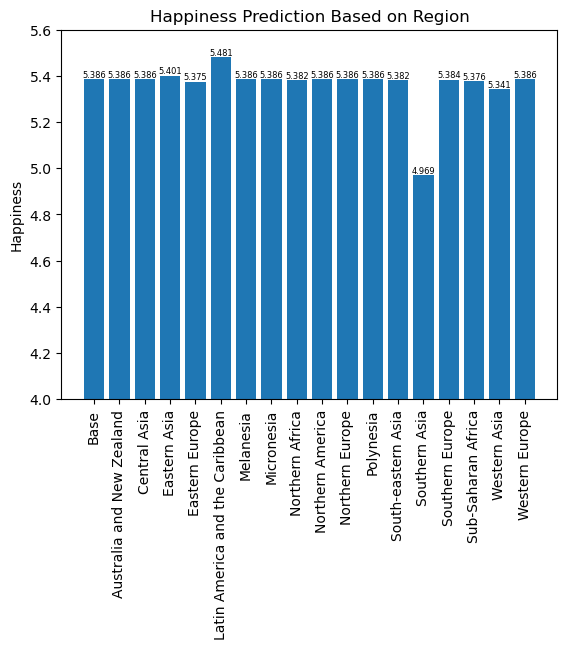

In [160]:
labels = ['Base'] + regions
fig, ax = plt.subplots()
rects = ax.bar(labels, predictions)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=6)

plt.xticks(rotation=90)
plt.ylabel("Happiness")
ax.set_ylim(4, 5.6)
plt.title("Happiness Prediction Based on Region")
plt.show()

**FOR INTRODUCTION**

In [78]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [79]:
def string_similarity(s1, s2):
    char_set = set(s1 + s2)
    common_count = 0
    for char in char_set:
        if char in s1 and char in s2:
            common_count += 1

    return common_count / len(char_set)

In [80]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Fill in countries with different names into the dataframe
countries_to_fill = list(set(dataframe['Country name'])-set(world['name']))
target_countries = list(set(world['name'])-set(dataframe['Country name']))
dataframe_copy = dataframe.copy()

for country in countries_to_fill:
    for target in target_countries:
        if country in target or target in country or string_similarity(country, target) > 0.7:
            for i in range(len(dataframe_copy)):
                if dataframe_copy['Country name'][i] == country:
                    dataframe_copy.loc[i, 'Country name'] = target

# Merge the data with the world map based on a common country column
merged_data = world.merge(dataframe_copy[['Country name', 'Ladder score']], left_on='name', right_on='Country name')

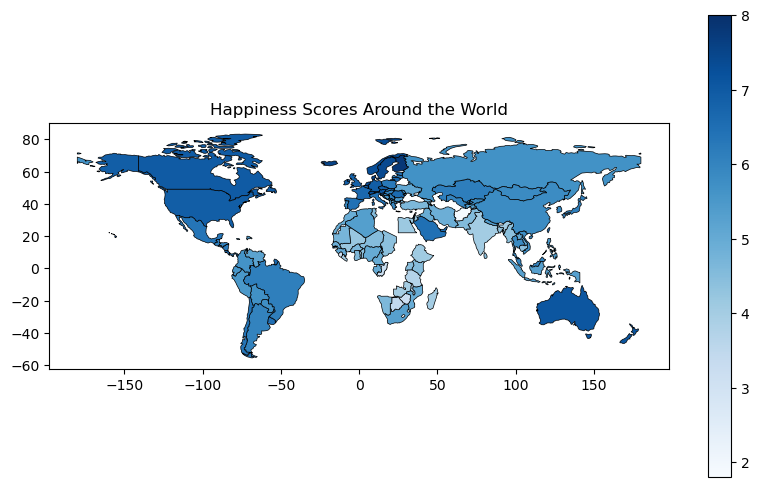

In [81]:
# Set the plot parameters and plot the map

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_aspect('equal')
merged_data.plot(column='Ladder score', cmap='Blues', linewidth=0.5, ax=ax, edgecolor='black', vmin=1.8, vmax=8,legend=True)
plt.title('Happiness Scores Around the World')
plt.show()

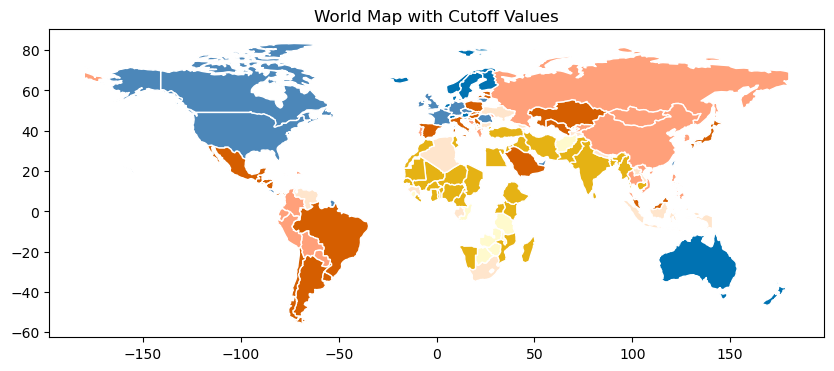

In [82]:
cutoffs = [4, 5, 5.5, 6, 6.5, 7]
colors = ['#FFFACD', '#E5B214', '#FFE5CC', '#FFA07A', '#D55E00', '#4C87B9', '#0072B2']

# create a function to assign colors based on cutoffs
def assign_color(value):
    for i, cutoff in enumerate(cutoffs):
        if value <= cutoff:
            return colors[i]
    return colors[-1]

# apply the function to the data column to assign colors
merged_data['color'] = merged_data['Ladder score'].apply(assign_color)

# plot the world map with colored countries
fig, ax = plt.subplots(figsize=(10, 6))
merged_data.plot(ax=ax, color=merged_data['color'], edgecolor='white')
ax.set_title('World Map with Cutoff Values')
plt.show()

In [90]:
import math
merged_data_GDP = world.merge(dataframe_copy[['Country name', 'Logged GDP per capita']], left_on='name', right_on='Country name')
merged_data_GDP['Logged GDP per capita'] = math.e**merged_data_GDP['Logged GDP per capita']

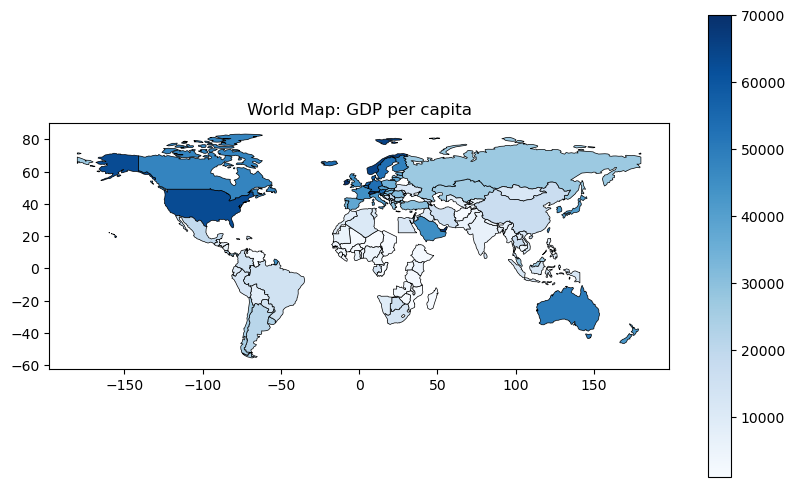

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_aspect('equal')
merged_data_GDP.plot(column='Logged GDP per capita', cmap='Blues', linewidth=0.5, ax=ax, edgecolor='black', vmin=1000, vmax=70000,legend=True)
plt.title('World Map: GDP per capita')
plt.show()

**REGION HISTOGRAMS**

In [97]:
for index, row in dataframe.iterrows():
    print(row)

Country name                                   Finland
Ladder score                                     7.804
Standard error of ladder score                   0.036
upperwhisker                                     7.875
lowerwhisker                                     7.733
Logged GDP per capita                           10.792
Social support                                   0.969
Healthy life expectancy                          71.15
Freedom to make life choices                     0.961
Generosity                                      -0.019
Perceptions of corruption                        0.182
Ladder score in Dystopia                         1.778
Explained by: Log GDP per capita                 1.888
Explained by: Social support                     1.585
Explained by: Healthy life expectancy            0.535
Explained by: Freedom to make life choices       0.772
Explained by: Generosity                         0.126
Explained by: Perceptions of corruption          0.535
Dystopia +